In [ ]:
import pickle,re, glob,os,random 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Flatten,Bidirectional,LSTM,Reshape
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import keras.backend as K 
from collections import defaultdict

def get_masked_input_and_labels(encoded_texts):
    # 20% BERT masking
    inp_mask = np.random.rand(*encoded_texts.shape) < 0.2
    # Do not mask special tokens
    inp_mask[encoded_texts <= 3] = False
    # Set targets to -1 by default, it means ignore
    labels = -1 * np.ones(encoded_texts.shape, dtype=int)
    # Set labels for masked tokens
    labels[inp_mask] = encoded_texts[inp_mask]

    # Prepare input
    encoded_texts_masked = np.copy(encoded_texts)
    # Set input to [MASK] which is the last token for the 90% of tokens
    # This means leaving 10% unchanged
    inp_mask_2mask = inp_mask & (np.random.rand(*encoded_texts.shape) < 0.90)
    encoded_texts_masked[
        inp_mask_2mask
    ] = mask_token_id  # mask token is the last in the dict

    # Set 10% to a random token
    inp_mask_2random = inp_mask_2mask & (np.random.rand(*encoded_texts.shape) < 1 / 9)
    encoded_texts_masked[inp_mask_2random] = np.random.randint(
        3, mask_token_id, inp_mask_2random.sum()
    )

    # Prepare sample_weights to pass to .fit() method
    sample_weights = np.ones(labels.shape)
    sample_weights[labels == -1] = 0

    # y_labels would be same as encoded_texts i.e input tokens
    y_labels = np.copy(encoded_texts)

    return encoded_texts_masked, y_labels, sample_weights

loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

def loadData(fname,printkeys='y'):
    # for reading also binary mode is important
    dbfile = open(fname, 'rb')     
    db = pickle.load(dbfile)
    if printkeys=='y':
        for keys in db:
            print(keys)
    return db



In [ ]:
!git clone https://github.com/dmamur/struct2prop.git 
!git clone https://github.com/ninarina12/phononDoS_tutorial.git
%cd phononDoS_tutorial

In [ ]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 32
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    MNAME = 'embed_pretrain_'
config = Config()
path="/content/struct2prop/models"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)+'_H_'+str(config.NUM_HEAD)+'_L_'+str(config.NUM_LAYERS)
tf.random.set_seed(42)

In [ ]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.0 MB/s eta 0:00:00


# Load data from Cif

In [ ]:
from ase.io import read
from ase import Atoms
from scipy.ndimage import gaussian_filter1d
from ase.neighborlist import neighbor_list
def getpdf(atoms,x,v):
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    pdfatoms=[]
    for k,l in enumerate(atoms):
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        pdfatoms.append(gaussian_filter1d(y/v,1))
    return np.asarray(pdfatoms)

formula
ids
types
xyz
cell
k2atoms


In [ ]:
# load data
df = pd.read_csv('data/data.csv')
df.head()

In [ ]:
r = np.arange(0,10,0.1)
v = np.concatenate([[1],4*np.pi/3*(r[1:]**3 - r[:-1]**3)])
types,formula,ids,pdf,phdos = [],[],[],[],[]
for index, row in df.iterrows():
  atoms=Atoms.fromdict(eval(row['structure']))
  formula.append(atoms.get_chemical_formula())
  types.append(atoms.get_chemical_symbols())
  pdf.append(getpdf(atoms,r,v))
ids=df['mp_id'].to_list()

93

In [ ]:
# Load data for masked language model
with open('/content/struct2prop/data/el2id.pkl', 'rb') as f:
    el2id = pickle.load(f)
element2id = el2id['el2id']
config.VOCAB_SIZE = len(element2id)
print(config.VOCAB_SIZE)

In [ ]:
typesNumerical=[]
for i in types:
    typesNumerical.append([element2id[j] for j in i])

x1 = tf.keras.preprocessing.sequence.pad_sequences(pdf,dtype='float32',padding= 'post',maxlen=config.MAX_LEN )
x1[np.isnan(x1)]=0
x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)

# Predict types
I shall use x_train2 as y_train but after replacing 20% of atoms with 0

In [ ]:
inputA = Input(shape=x1.shape[1:],name='x1')
inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')

x = Bidirectional(LSTM(8,name='x1_lstm',return_sequences=True),name='x1_blstm')(inputA)
x = Model(inputs=inputA, outputs=x)

z =  Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)
combined = Concatenate()([x.output,z.output])

e = Dense(512, activation="relu",use_bias=True)(combined)
e = Dense(config.VOCAB_SIZE, activation="softmax")(e)
# our model will accept the inputs of the two branches and then output a single value
model = MaskedLanguageModel(inputs=[x.input,z.input], outputs=e)

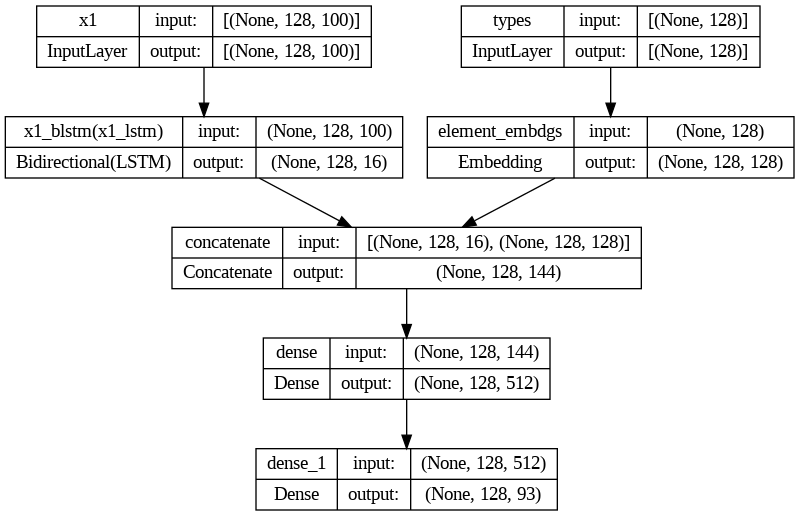

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

In [ ]:
model.summary()

Model: "masked_language_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x1 (InputLayer)                [(None, 128, 100)]   0           []                               
                                                                                                  
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 x1_blstm (Bidirectional)       (None, 128, 16)      6976        ['x1[0][0]']                     
                                                                                                  
 element_embdgs (Embedding)     (None, 128, 128)     11904       ['types[0][0]']                  
                                                                              

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=config.LR)
model.compile(optimizer=optimizer)

In [ ]:
epochs=10*config.BATCH_SIZE
csv_logger = keras.callbacks.CSVLogger(mname+"_log.csv", append=True)
checkpoint = keras.callbacks.ModelCheckpoint(mname+".h5",verbose=1, mode='min',save_freq=5000)
callbacks_list = [checkpoint,csv_logger]
hist = model.fit([x1,x_masked_train],y_masked_labels,
                 sample_weight=sample_weights,epochs=epochs, callbacks = callbacks_list,batch_size=config.BATCH_SIZE)
model.save(mname+".h5")

Epoch 1/1600
1767/1767 [==============================] - 46s 20ms/step - loss: 2.2047
Epoch 2/1600
1767/1767 [==============================] - 30s 17ms/step - loss: 1.7153
Epoch 3/1600
1463/1767 [=======================>......] - ETA: 4s - loss: 1.6047
Epoch 3: saving model to /content/gdrive/MyDrive/e3nn/embed_rdf_pretrainTest_E_128_H_4_L_1.h5
1767/1767 [==============================] - 28s 16ms/step - loss: 1.5946
Epoch 4/1600
1767/1767 [==============================] - 27s 15ms/step - loss: 1.5169
Epoch 5/1600
1767/1767 [==============================] - 27s 15ms/step - loss: 1.4593
Epoch 6/1600
1161/1767 [==================>...........] - ETA: 9s - loss: 1.4115
Epoch 6: saving model to /content/gdrive/MyDrive/e3nn/embed_rdf_pretrainTest_E_128_H_4_L_1.h5
1767/1767 [==============================] - 28s 16ms/step - loss: 1.4148
Epoch 7/1600
1767/1767 [==============================] - 28s 16ms/step - loss: 1.3731
Epoch 8/1600
1767/1767 [==============================] - 27s 15ms/

KeyboardInterrupt: ignored